## **Imports**

In [1]:
!pip install optuna
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_info_columns', 200)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Data**

In [5]:
odf = pd.read_pickle("/content/drive/MyDrive/Semester 3/DL/Shiv/final_df.pkl")

## **Feature Engineering**

In [7]:
df = odf[[
       #'subject_id_x', , 'cxr_path', 'Atelectasis', 'Cardiomegaly',
       #'Edema', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'ecg_path',
       #'Hematocrit', 'Platelet Count', 'Creatinine', 'Potassium', 'Hemoglobin',
       #'White Blood Cells', 'MCHC', 'Red Blood Cells', 'MCV', 'MCH', 'RDW',
       #'Urea Nitrogen', 'Sodium', 'Chloride', 'Bicarbonate', 'Anion Gap',
       #'Glucose', 'Magnesium', 'Calcium, Total', 'Phosphate', 'INR(PT)', 'PT',
       #'PTT', 'Basophils', 'Neutrophils', 'Monocytes', 'Eosinophils',
       #'Lymphocytes', 'RDW-SD', 'H', 'L', 'I',
       #'Alanine Aminotransferase (ALT)', 'Asparate Aminotransferase (AST)',
       #'Lactate', 'Alkaline Phosphatase', 'Bilirubin, Total', 'pH', 'Albumin',
       #'Base Excess', 'pO2', 'Calculated Total CO2', 'pCO2',
       #'Absolute Neutrophil Count', 'Absolute Eosinophil Count',
       #'Absolute Monocyte Count', 'Absolute Basophil Count',
       #'Absolute Lymphocyte Count', 'Creatine Kinase (CK)',
       #'Immature Granulocytes',
       'Hematocrit_percentile', 'hadm_id',
       'Platelet Count_percentile', 'Creatinine_percentile',
       'Potassium_percentile', 'Hemoglobin_percentile',
       'White Blood Cells_percentile', 'MCHC_percentile',
       'Red Blood Cells_percentile', 'MCV_percentile', 'MCH_percentile',
       'RDW_percentile', 'Urea Nitrogen_percentile', 'Sodium_percentile',
       'Chloride_percentile', 'Bicarbonate_percentile', 'Anion Gap_percentile',
       'Glucose_percentile', 'Magnesium_percentile',
       'Calcium, Total_percentile', 'Phosphate_percentile',
       'INR(PT)_percentile', 'PT_percentile', 'PTT_percentile',
       'Basophils_percentile', 'Neutrophils_percentile',
       'Monocytes_percentile', 'Eosinophils_percentile',
       'Lymphocytes_percentile', 'RDW-SD_percentile', 'H_percentile',
       'L_percentile', 'I_percentile',
       'Alanine Aminotransferase (ALT)_percentile',
       'Asparate Aminotransferase (AST)_percentile', 'Lactate_percentile',
       'Alkaline Phosphatase_percentile', 'Bilirubin, Total_percentile',
       'pH_percentile', 'Albumin_percentile', 'Base Excess_percentile',
       'pO2_percentile', 'Calculated Total CO2_percentile', 'pCO2_percentile',
       'Absolute Neutrophil Count_percentile',
       'Absolute Eosinophil Count_percentile',
       'Absolute Monocyte Count_percentile',
       'Absolute Basophil Count_percentile',
       'Absolute Lymphocyte Count_percentile',
       'Creatine Kinase (CK)_percentile', 'Immature Granulocytes_percentile',
       'image',
       #'label_hadm_id', 'label', 'subject_id_y', 'hospital_expire_flag', 'dicom_id', 'discharge_location', 'admission_type',
       'admission_location',
       #'Consolidation', 'Enlarged Cardiomediastinum','Fracture', 'Lung Lesion', 'Pleural Other',  'Pneumothorax', 'Support Devices',
       'Pneumonia', 'race', 'gender', 'age',
       'ViewPosition']].copy()

In [8]:
df.shape

(2478, 58)

In [9]:
def simplify_race(raw):
    if pd.isna(raw):
        return "Unknown/Refused"
    r = str(raw).strip().upper()

    # Unknown / refused
    if r in ["UNKNOWN", "UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER"]:
        return "Unknown/Refused"

    # White
    if r.startswith("WHITE") or r in ["PORTUGUESE"]:
        return "White"

    # Black
    if r.startswith("BLACK/") or r == "BLACK/AFRICAN":
        return "Black"

    # Hispanic / Latino
    if "HISPANIC" in r or "LATINO" in r or r in ["SOUTH AMERICAN"]:
        return "Hispanic/Latino"

    # Asian
    if r.startswith("ASIAN"):
        return "Asian"

    # Native American / Pacific Islander
    if r in ["AMERICAN INDIAN/ALASKA NATIVE", "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER"]:
        return "Other"

    # Multiple / other
    if r in ["MULTIPLE RACE/ETHNICITY", "OTHER"]:
        return "Other"

    # Fallback
    return "Other"

df["race_grouped"] = df["race"].apply(simplify_race)


In [10]:
bins = [0, 40, 60, 80, 120]
labels = ["18–40", "40–60", "60–80", "80+"]

df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

In [11]:
df = df[['Hematocrit_percentile', 'Platelet Count_percentile',
       'Creatinine_percentile', 'Potassium_percentile',
       'Hemoglobin_percentile', 'White Blood Cells_percentile',
       'MCHC_percentile', 'Red Blood Cells_percentile', 'MCV_percentile',
       'MCH_percentile', 'RDW_percentile', 'Urea Nitrogen_percentile',
       'Sodium_percentile', 'Chloride_percentile', 'Bicarbonate_percentile',
       'Anion Gap_percentile', 'Glucose_percentile', 'Magnesium_percentile',
       'Calcium, Total_percentile', 'Phosphate_percentile',
       'INR(PT)_percentile', 'PT_percentile', 'PTT_percentile',
       'Basophils_percentile', 'Neutrophils_percentile',
       'Monocytes_percentile', 'Eosinophils_percentile',
       'Lymphocytes_percentile', 'RDW-SD_percentile', 'H_percentile',
       'L_percentile', 'I_percentile',
       'Alanine Aminotransferase (ALT)_percentile',
       'Asparate Aminotransferase (AST)_percentile', 'Lactate_percentile',
       'Alkaline Phosphatase_percentile', 'Bilirubin, Total_percentile',
       'pH_percentile', 'Albumin_percentile', 'Base Excess_percentile',
       'pO2_percentile', 'Calculated Total CO2_percentile', 'pCO2_percentile',
       'Absolute Neutrophil Count_percentile',
       'Absolute Eosinophil Count_percentile',
       'Absolute Monocyte Count_percentile',
       'Absolute Basophil Count_percentile',
       'Absolute Lymphocyte Count_percentile',
       'Creatine Kinase (CK)_percentile', 'Immature Granulocytes_percentile',
       'image', 'admission_location', 'Pneumonia',   'race_grouped', 'age_group'
       #'race', 'gender', 'age', 'ViewPosition',
       ]].copy()

## **XG-Boost Model**

In [12]:
X = df.drop(columns=['Pneumonia', 'image'], errors='ignore')
y = df['Pneumonia']

lab_cols = [col for col in X.columns if col.endswith('_percentile')]
cat_cols = ['admission_location', 'race_grouped', 'age_group']

drop_labs = ['H_percentile', 'L_percentile', 'I_percentile']
lab_cols = [col for col in lab_cols if col not in drop_labs]

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, cat_cols),
    ('lab', 'passthrough', lab_cols)
], remainder='drop')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

from xgboost import XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='auc',
                        tree_method='hist', use_label_encoder=False, random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb_clf)
])
param_distributions = {
    'clf__n_estimators': [100, 200, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [3, 4, 5, 6, 8],
    'clf__min_child_weight': [1, 3, 5, 10],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 0.2, 1.0],
    'clf__reg_lambda': [0, 1, 5, 10],
    'clf__reg_alpha': [0, 0.1, 1, 5]
}
neg, pos = np.bincount(y_train)
if pos > 0:
    scale_pos_weight = neg / pos
    param_distributions['clf__scale_pos_weight'] = [1, scale_pos_weight]
else:
    param_distributions['clf__scale_pos_weight'] = [1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_distributions,
    n_iter=50, scoring='roc_auc', cv=cv, n_jobs=-1,
    verbose=1, random_state=42
)
random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)
print("Best CV ROC-AUC: {:.3f}".format(random_search.best_score_))

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test ROC-AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Test Precision: {:.3f}".format(precision_score(y_test, y_pred)))
print("Test Recall: {:.3f}".format(recall_score(y_test, y_pred)))
print("Test F1-score: {:.3f}".format(f1_score(y_test, y_pred)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:49:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'clf__subsample': 1.0, 'clf__scale_pos_weight': 1, 'clf__reg_lambda': 0, 'clf__reg_alpha': 1, 'clf__n_estimators': 200, 'clf__min_child_weight': 3, 'clf__max_depth': 6, 'clf__learning_rate': 0.01, 'clf__gamma': 0, 'clf__colsample_bytree': 0.6}
Best CV ROC-AUC: 0.628
Test ROC-AUC: 0.667
Test Accuracy: 0.618
Test Precision: 0.599
Test Recall: 0.557
Test F1-score: 0.577
Confusion Matrix:
 [[133  65]
 [ 77  97]]
Classification Report:
               precision    recall  f1-score   support

           0      0.633     0.672     0.652       198
           1      0.599     0.557     0.577       174

    accuracy                          0.618       372
   macro avg      0.616     0.615     0.615       372
weighted avg      0.617     0.618     0.617       372



<Figure size 600x600 with 0 Axes>

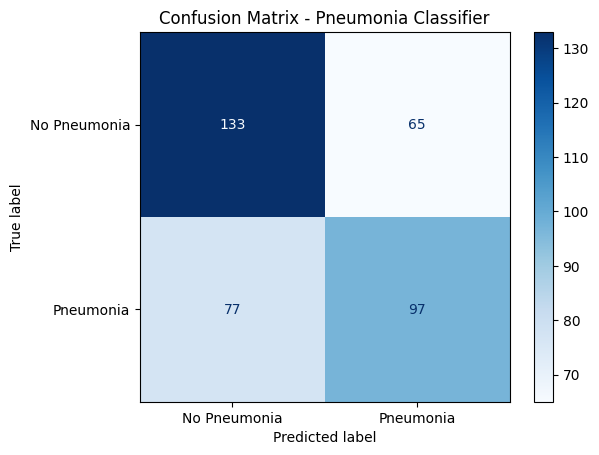

In [25]:
cm = confusion_matrix(y_test, y_pred)
class_names = ["No Pneumonia", "Pneumonia"]

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix - Pneumonia Classifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()


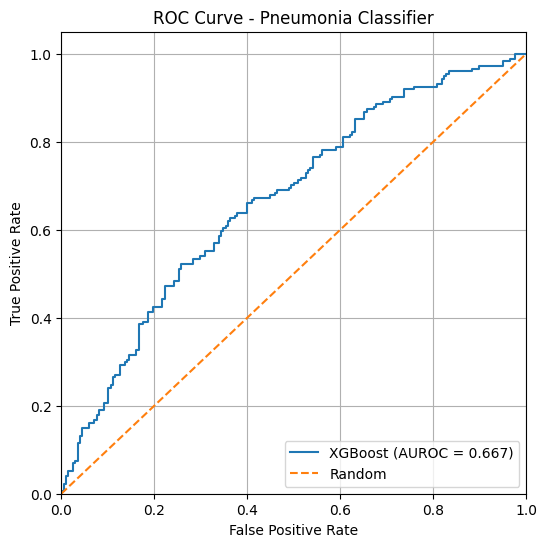

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **Fully Connected MLP Model**

In [13]:
if 'image' in df.columns:
    df = df.drop(columns=['image'])

X = df.drop(columns=['Pneumonia'])
y = df['Pneumonia'].values

train_X, temp_X, train_y, temp_y = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(
    temp_X, temp_y, test_size=0.50, stratify=temp_y, random_state=42)

train_X = train_X.reset_index(drop=True)
val_X = val_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)


In [14]:

class LabBinner:
    def __init__(self, drop_sparse=True):
        self.bin_edges = [10, 25, 75, 90, 100]
        self.drop_sparse = drop_sparse
        self.lab_cols = []
        self.dropped_labs = []
    def fit(self, df):
        all_lab_cols = [col for col in df.columns if col.endswith('_percentile')]

        sparse_candidates = ['H_percentile', 'L_percentile', 'I_percentile']
        if self.drop_sparse:
            self.dropped_labs = [col for col in all_lab_cols if col in sparse_candidates]

        self.lab_cols = [col for col in all_lab_cols if col not in self.dropped_labs]
        return self
    def transform(self, df):
        df_trans = df.copy()
        if self.dropped_labs:
            df_trans.drop(columns=self.dropped_labs, inplace=True, errors='ignore')
        for col in self.lab_cols:
            new_col = col[:-len('_percentile')] + '_bin'
            values = df_trans[col].values.astype(float)
            binned = np.full(values.shape, fill_value=len(self.bin_edges), dtype=np.int64)
            not_nan = ~np.isnan(values)
            vals = values[not_nan]
            binned_vals = np.zeros(vals.shape, dtype=np.int64)
            binned_vals[vals <= 10] = 0
            binned_vals[(vals > 10) & (vals <= 25)] = 1
            binned_vals[(vals > 25) & (vals <= 75)] = 2
            binned_vals[(vals > 75) & (vals <= 90)] = 3
            binned_vals[vals > 90] = 4
            binned[not_nan] = binned_vals
            df_trans[new_col] = binned
        df_trans.drop(columns=self.lab_cols, inplace=True, errors='ignore')
        return df_trans
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

class CatEncoder:
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        self.category_maps = {}

    def fit(self, df):
        for col in self.cat_cols:
            col_vals = df[col].astype(object)
            unique_vals = pd.Series(col_vals.dropna().unique())
            mapping = {"<UNK>": 0}
            for i, val in enumerate(unique_vals, start=1):
                mapping[val] = i

            self.category_maps[col] = mapping
        return self

    def transform(self, df):
        df_trans = df.copy()
        for col, mapping in self.category_maps.items():
            if col in df_trans.columns:
                col_vals = df_trans[col].astype(object)
                encoded = col_vals.map(mapping)
                encoded = encoded.fillna(0).astype(int)
                df_trans[col] = encoded
        return df_trans

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

class AgeScaler:
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, df):
        if 'age' in df.columns:
            self.scaler.fit(df[['age']])
        return self
    def transform(self, df):
        df_trans = df.copy()
        if 'age' in df_trans.columns:
            df_trans['age_scaled'] = self.scaler.transform(df_trans[['age']])
            df_trans.drop(columns=['age'], inplace=True)
        return df_trans
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


In [15]:

lab_binner = LabBinner(drop_sparse=True)
cat_cols = ['admission_location', 'race_grouped', 'age_group']
cat_encoder = CatEncoder(cat_cols=cat_cols)

train_feat = lab_binner.fit_transform(train_X)
val_feat   = lab_binner.transform(val_X)
test_feat  = lab_binner.transform(test_X)

train_feat = cat_encoder.fit_transform(train_feat)
val_feat   = cat_encoder.transform(val_feat)
test_feat  = cat_encoder.transform(test_feat)



In [16]:


class PneumoniaDataset(Dataset):
    def __init__(self, features_df, labels, lab_bin_cols, cat_cols):
        self.df = features_df.reset_index(drop=True)
        self.labels = labels
        self.lab_bin_cols = lab_bin_cols
        self.cat_cols = cat_cols
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        lab_bins = row[self.lab_bin_cols].astype(np.int64).values
        cat_feats = row[self.cat_cols].astype(np.int64).values

        label = np.array([self.labels[idx]], dtype=np.float32)
        lab_bins = torch.tensor(lab_bins, dtype=torch.long)
        cat_feats = torch.tensor(cat_feats, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.float32)
        return lab_bins, cat_feats,  label

lab_bin_cols = [col for col in train_feat.columns if col.endswith('_bin')]

train_dataset = PneumoniaDataset(train_feat, train_y, lab_bin_cols, cat_cols)
val_dataset   = PneumoniaDataset(val_feat,   val_y,   lab_bin_cols, cat_cols)
test_dataset  = PneumoniaDataset(test_feat,  test_y,  lab_bin_cols, cat_cols)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:


class PneumoniaMLP(nn.Module):
    def __init__(self, num_lab_features, lab_emb_dim, cat_dims, cat_emb_dim,
                 hidden_dim, num_layers, dropout):
        super(PneumoniaMLP, self).__init__()
        self.lab_embeds = nn.ModuleList([
            nn.Embedding(num_embeddings=6, embedding_dim=lab_emb_dim)
            for _ in range(num_lab_features)
        ])
        self.cat_embeds = nn.ModuleList([
            nn.Embedding(num_embeddings=cat_dim, embedding_dim=cat_emb_dim)
            for cat_dim in cat_dims
        ])
        input_dim = num_lab_features * lab_emb_dim + len(cat_dims) * cat_emb_dim
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = hidden_dim
            self.layers.append(nn.Linear(in_dim, out_dim))
            self.layers.append(nn.BatchNorm1d(out_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
        final_in_dim = hidden_dim if num_layers > 0 else input_dim
        self.output_layer = nn.Linear(final_in_dim, 1)

    def forward(self, lab_bins, cat_feats):
        lab_emb_list = [emb(lab_bins[:, i]) for i, emb in enumerate(self.lab_embeds)]
        if len(lab_emb_list) > 0:
            lab_embedded = torch.cat(lab_emb_list, dim=1)
        else:
            lab_embedded = torch.empty(lab_bins.size(0), 0)
        cat_emb_list = [emb(cat_feats[:, j]) for j, emb in enumerate(self.cat_embeds)]
        if len(cat_emb_list) > 0:
            cat_embedded = torch.cat(cat_emb_list, dim=1)
        else:
            cat_embedded = torch.empty(cat_feats.size(0), 0)
        x = torch.cat([lab_embedded, cat_embedded], dim=1)
        for layer in self.layers:
            x = layer(x)
        logit = self.output_layer(x)
        return logit


In [18]:
num_lab_features = len(lab_bin_cols)
cat_dims = [len(cat_encoder.category_maps[col]) for col in cat_cols]


In [19]:
from sklearn.metrics import roc_auc_score

def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, weight_decay=0.0, patience=5, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_auc = 0.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_train_loss = 0.0
        # Training loop
        for lab_bins, cat_feats, labels in train_loader:
            lab_bins, cat_feats,  labels = lab_bins.to(device), cat_feats.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(lab_bins, cat_feats)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0.0
        all_probs = []
        all_labels = []
        with torch.no_grad():
            for lab_bins, cat_feats,  labels in val_loader:
                lab_bins, cat_feats,  labels = lab_bins.to(device), cat_feats.to(device), labels.to(device)
                logits = model(lab_bins, cat_feats)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()
                probs = torch.sigmoid(logits)
                all_probs.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        avg_val_loss = total_val_loss / len(val_loader)
        all_probs = np.concatenate(all_probs).flatten()
        all_labels = np.concatenate(all_labels).flatten()
        val_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) == 2 else 0.0

        if verbose:
            print(f"Epoch {epoch}: TrainLoss={avg_train_loss:.4f}, ValLoss={avg_val_loss:.4f}, ValAUC={val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            if verbose:
                print(f"Early stopping triggered after {epoch} epochs. Best Val AUC: {best_val_auc:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_auc


In [20]:
 def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    emb_dim_lab = trial.suggest_categorical('emb_dim_lab', [4, 8, 16])
    emb_dim_cat = trial.suggest_categorical('emb_dim_cat', [4, 8, 16])
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_categorical('dropout', [0.1, 0.3, 0.5])
    weight_decay = trial.suggest_categorical('weight_decay', [0.0, 1e-4, 1e-3])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = PneumoniaMLP(num_lab_features=num_lab_features, lab_emb_dim=emb_dim_lab,
                         cat_dims=cat_dims, cat_emb_dim=emb_dim_cat,
                         hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    val_auc = train_model(model, train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, patience=5, verbose=False)
    return val_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=False)


[I 2025-12-14 01:49:14,812] A new study created in memory with name: no-name-21e54927-7566-4a6c-836e-c2133fd5a862
[I 2025-12-14 01:49:39,985] Trial 0 finished with value: 0.5723422770123279 and parameters: {'lr': 0.0007796497639709539, 'batch_size': 32, 'emb_dim_lab': 4, 'emb_dim_cat': 4, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.3, 'weight_decay': 0.0}. Best is trial 0 with value: 0.5723422770123279.
[I 2025-12-14 01:49:53,804] Trial 1 finished with value: 0.5787817258883248 and parameters: {'lr': 0.0009848979633686051, 'batch_size': 128, 'emb_dim_lab': 16, 'emb_dim_cat': 8, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3, 'weight_decay': 0.0}. Best is trial 1 with value: 0.5787817258883248.
[I 2025-12-14 01:50:10,726] Trial 2 finished with value: 0.5892675852066716 and parameters: {'lr': 0.00038945864295882905, 'batch_size': 64, 'emb_dim_lab': 16, 'emb_dim_cat': 16, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1, 'weight_decay': 0.0001}. Best is trial 2 with value: 0.5892

In [21]:
best_trial = study.best_trial
print("Best Hyperparameters:", best_trial.params)
print(f"Best validation ROC-AUC: {best_trial.value:.4f}")


Best Hyperparameters: {'lr': 0.0020347583043203985, 'batch_size': 32, 'emb_dim_lab': 8, 'emb_dim_cat': 16, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.5, 'weight_decay': 0.0}
Best validation ROC-AUC: 0.6077


In [22]:
best_params = best_trial.params
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']
best_emb_dim_lab = best_params['emb_dim_lab']
best_emb_dim_cat = best_params['emb_dim_cat']
best_hidden_dim = best_params['hidden_dim']
best_num_layers = best_params['num_layers']
best_dropout = best_params['dropout']
best_weight_decay = best_params['weight_decay']

best_model = PneumoniaMLP(num_lab_features=num_lab_features, lab_emb_dim=best_emb_dim_lab,
                           cat_dims=cat_dims, cat_emb_dim=best_emb_dim_cat,
                           hidden_dim=best_hidden_dim, num_layers=best_num_layers,
                           dropout=best_dropout)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

print("Training final model with best hyperparameters...")
train_model(best_model, train_loader, val_loader, epochs=50, lr=best_lr, weight_decay=best_weight_decay, patience=5, verbose=True)


Training final model with best hyperparameters...
Epoch 1: TrainLoss=0.7144, ValLoss=0.6813, ValAUC=0.6007
Epoch 2: TrainLoss=0.7103, ValLoss=0.6851, ValAUC=0.5786
Epoch 3: TrainLoss=0.6865, ValLoss=0.6791, ValAUC=0.5963
Epoch 4: TrainLoss=0.6856, ValLoss=0.6846, ValAUC=0.5672
Epoch 5: TrainLoss=0.6839, ValLoss=0.6812, ValAUC=0.5781
Epoch 6: TrainLoss=0.6822, ValLoss=0.6828, ValAUC=0.5730
Early stopping triggered after 6 epochs. Best Val AUC: 0.6007


np.float64(0.6006961566352429)

In [23]:
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)

all_probs = []
all_true = []
with torch.no_grad():
    for lab_bins, cat_feats,  labels in test_loader:
        lab_bins, cat_feats,  labels = lab_bins.to(device), cat_feats.to(device), labels.to(device)
        logits = best_model(lab_bins, cat_feats )
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(labels.cpu().numpy())
all_probs = np.concatenate(all_probs).flatten()
all_true = np.concatenate(all_true).flatten().astype(int)

pred_labels = (all_probs >= 0.5).astype(int)

test_auc = roc_auc_score(all_true, all_probs)
test_acc = accuracy_score(all_true, pred_labels)
test_precision = precision_score(all_true, pred_labels)
test_recall = recall_score(all_true, pred_labels)
test_f1 = f1_score(all_true, pred_labels)

print(f"Test ROC-AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:\n", classification_report(all_true, pred_labels, digits=3))
print("Confusion Matrix:\n", confusion_matrix(all_true, pred_labels))


Test ROC-AUC: 0.6064
Test Accuracy: 0.5860
Classification Report:
               precision    recall  f1-score   support

           0      0.615     0.596     0.605       198
           1      0.556     0.575     0.565       174

    accuracy                          0.586       372
   macro avg      0.585     0.585     0.585       372
weighted avg      0.587     0.586     0.586       372

Confusion Matrix:
 [[118  80]
 [ 74 100]]


<Figure size 600x600 with 0 Axes>

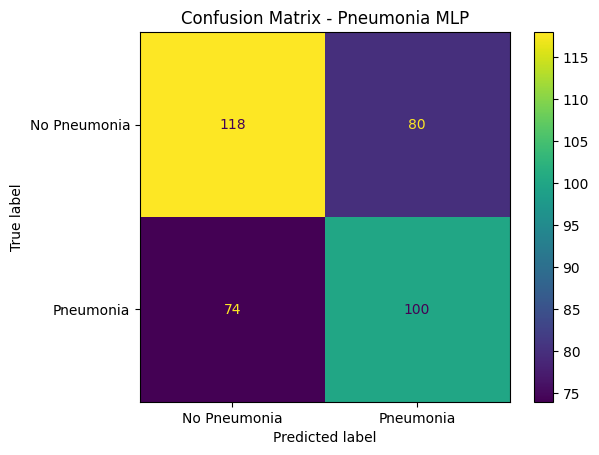

In [27]:
cm = confusion_matrix(all_true, pred_labels)

class_names = ["No Pneumonia", "Pneumonia"]

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format='d')
plt.title("Confusion Matrix - Pneumonia MLP")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.show()


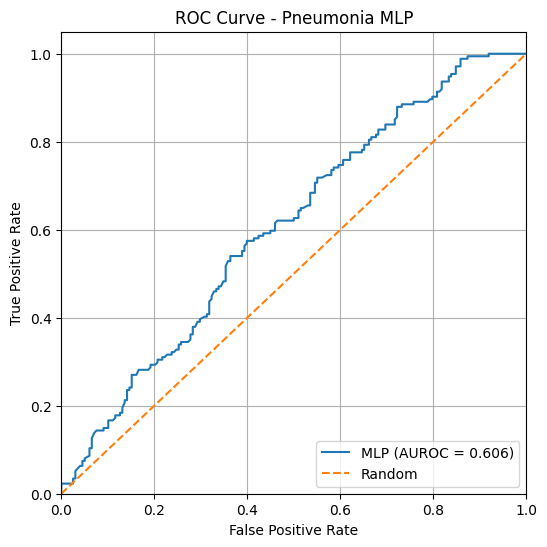

In [28]:
fpr, tpr, thresholds = roc_curve(all_true, all_probs)
roc_auc = roc_auc_score(all_true, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"MLP (AUROC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia MLP")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
